<a href="https://colab.research.google.com/github/jeonggunlee/DeepLearningBasics/blob/master/Lab05_classifying_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###한림대학교 소프트웨어 융합 대학 
##Keras를 활용한 딥러닝 기초 (2020년 8월 5일)

이정근 교수

   - Homepage: http://www.onchip.net
   - Email: jeonggun.lee@hallym.ac.kr / jeonggun.lee@gmail.com 


---
## IMDB 리뷰 감성 분류하기

imdb의 데이터 로딩 화일이 이전 버전의 numpy를 활용하기 때문에, 이전 numpy 버전(1.16.2)을 새롭게 설치해야 합니다.

이를 위하여 다음 명령어를 수행

**!pip install numpy==1.16.2**


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

참고 사이트

   - https://github.com/rickiepark/deep-learning-with-python-notebooks
   - 원작자: François Chollet, https://github.com/fchollet
   - 한글화: Haesun Park (rickiepark) https://github.com/rickiepark
---

# 영화 리뷰 분류: 이진 분류 예제

이진 분류 (binary classification)는 아마도 가장 널리 적용된 머신 러닝 문제일 것입니다. 이 예제에서 리뷰 텍스트를 기반으로 영화 리뷰를 긍정 (positive)과 부정(negative)로 분류하는 법을 배우겠습니다.

## IMDB 데이터셋

- 인터넷 영화 데이터베이스 (Internet Movie Database, IMDB)
- 양극단의 리뷰 50,000개로 이루어진 IMDB 데이터셋을 사용
- 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 구성
   - 각각 50%는 부정, 50%는 긍정 리뷰로 구성

- IMDB 데이터셋도 케라스에 포함
 ```python
  from keras.datasets import imdb
  ```
- 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있음
   - 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


- `num_words=10000`은 데이터에서 가장 자주 나타나는 단어 10,000개만 사용함을 의미
- 변수 `train_data`와 `test_data`는 리뷰의 목록
- 각 리뷰는 단어 인덱스의 리스트(단어 시퀀스가 인코딩된 것)
-  `train_labels`와 `test_labels`는 부정을 나타내는 0과 긍정을 나타내는 1의 리스트

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

- 자주 등장하는 단어 10,000개로 제한했기 때문에 단어 인덱스는 10,000을 넘지 않음

In [5]:
max([max(sequence) for sequence in train_data])

9999

- 리뷰 데이터 하나를 원래 영어 단어로 어떻게 바꾸는 과정

In [6]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리입니다
word_index = imdb.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집습니다
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩합니다. 
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 데이터 준비

신경망에 숫자 리스트를 주입할 수는 없습니다. 리스트를 텐서로 바꾸는 방법:

- 같은 길이가 되도록 리스트에 패딩을 추가하고 `(samples, sequence_length)` 크기의 정수 텐서로 변환
- 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환
- 예를 들면 시퀀스 `[3, 5]`를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환
- 그다음 부동 소수 벡터 데이터를 다룰 수 있는 `Dense` 층을 신경망의 첫 번째 층으로 사용

이해를 돕기 위해 직접 데이터를 원-핫 벡터로 만들겠습니다:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(test_data)

샘플은 다음과 같이 나타남:

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

레이블은 쉽게 벡터로 바꿀 수 있음:

In [10]:
# 레이블을 벡터로 바꿉니다
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

이제 신경망에 주입할 데이터가 준비

## 신경망 모델 만들기

* 16개의 은닉 유닛을 가진 두 개의 은닉층
* 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층

- 중간에 있는 은닉층은 활성화 함수로 `relu`를 사용
- 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미합니다)을 출력하기 위해 시그모이드 활성화 함수를 사용


![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

손실 함수와 옵티마이저를 선택
   - 이진 분류 문제이고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았습니다), `binary_crossentropy` 손실이 적합

다음은 `rmsprop` 옵티마이저와 `binary_crossentropy` 손실 함수로 모델을 설정
   - 훈련하는 동안 정확도를 사용해 모니터링

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

- 케라스에 `rmsprop`, `binary_crossentropy`, `accuracy`가 포함

In [13]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [15]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만듦:

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

- 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련
   - `x_train`과 `y_train` 텐서에 있는 모든 샘플에 대해 20번 반복
- 동시에 따로 떼어 놓은 10,000개의 샘플에서 손실과 정확도를 측정
- `validation_data` 매개변수에 검증 데이터를 전달:

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 193us/step - loss: 0.5292 - accuracy: 0.7935 - val_loss: 0.4098 - val_accuracy: 0.8577
Epoch 2/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.3261 - accuracy: 0.8975 - val_loss: 0.3142 - val_accuracy: 0.8859
Epoch 3/20
15000/15000 [==============================] - 1s 74us/step - loss: 0.2393 - accuracy: 0.9235 - val_loss: 0.2860 - val_accuracy: 0.8877
Epoch 4/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.1895 - accuracy: 0.9396 - val_loss: 0.2968 - val_accuracy: 0.8800
Epoch 5/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.1554 - accuracy: 0.9509 - val_loss: 0.2907 - val_accuracy: 0.8842
Epoch 6/20
15000/15000 [==============================] - 1s 71us/step - loss: 0.1293 - accuracy: 0.9588 - val_loss: 0.2826 - val_accuracy: 0.8893
Epoch 7/20
15000/15000 [==============================] - 1s 72us/s

- `model.fit()` 메서드는 `History` 객체를 반환
- 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 `history` 속성을 가지고 있음:

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

- 이 딕셔너리는 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 네 개의 항목을 포함
- 맷플롯립을 사용해 훈련과 검증 데이터에 대한 손실과 정확도 display:

In [19]:
import matplotlib.pyplot as plt

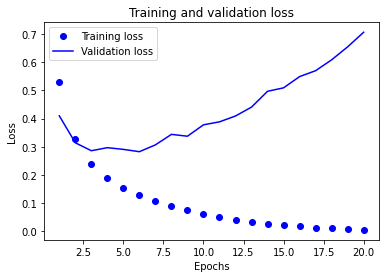

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

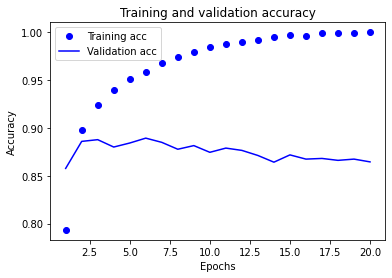

In [21]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 1s 55us/step - loss: 0.4865 - accuracy: 0.8046
Epoch 2/4
25000/25000 [==============================] - 1s 51us/step - loss: 0.2776 - accuracy: 0.9085
Epoch 3/4
25000/25000 [==============================] - 1s 51us/step - loss: 0.2091 - accuracy: 0.9270
Epoch 4/4
25000/25000 [==============================] - 2s 97us/step


In [23]:
results

[0.28782773162841796, 0.8868399858474731]

- 단순한 방식으로도 87%의 정확도를 달성

## 훈련된 모델로 새로운 데이터에 대해 예측하기

In [24]:
model.predict(x_test)

array([[0.21431123],
       [0.99819654],
       [0.83573806],
       ...,
       [0.11186426],
       [0.08854643],
       [0.5961568 ]], dtype=float32)

## 추가 실험

* 여기에서는 두 개의 은닉층을 사용했습니다. 한 개 또는 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인해 보세요.
* 층의 은닉 유닛을 추가하거나 줄여 보세요: 32개 유닛, 64개 유닛 등
* `binary_crossentropy` 대신에 `mse` 손실 함수를 사용해 보세요.
* `relu` 대신에 `tanh` 활성화 함수(초창기 신경망에서 인기 있었던 함수입니다)를 사용해 보세요.

다음 실험을 진행하면 여기에서 선택한 구조가 향상의 여지는 있지만 어느 정도 납득할 만한 수준이라는 것을 알게 것입니다!

## 정리

다음은 이 예제에서 배운 것들입니다:

* 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요합니다. 단어 시퀀스는 이진 벡터로 인코딩될 수 있고 다른 인코딩 방식도 있습니다.
* `relu` 활성화 함수와 함께 `Dense` 층을 쌓은 네트워크는 (감성 분류를 포함하여) 여러 종류의 문제에 적용할 수 있어서 앞으로 자주 사용하게 될 것입니다.
* (출력 클래스가 두 개인) 이진 분류 문제에서 네트워크는 하나의 유닛과 `sigmoid` 활성화 함수를 가진 `Dense` 층으로 끝나야 합니다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값입니다.
* 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 `binary_crossentropy`입니다.
* `rmsprop` 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택입니다. 걱정할 거리가 하나 줄은 셈입니다.
* 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적 없는 데이터에서는 결과가 점점 나빠지게 됩니다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 합니다.